# Three Qubit Classification using proposed circuit 

The below model classifies the three qubit entanglement classes using proposed quantum neural network model. It outperformed qiskit pre-defined ansatz like RealAmplitude. EfficienSU2


### Importing necessary packages

In [45]:
# Importing basic python packages for Data handling 

import numpy as np
%matplotlib inline
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import plotly.express as px
from IPython.display import clear_output

# Importing python packages for Math operations

from scipy.linalg import sqrtm, eig
import math
from sympy import symbols, sqrt

# Importing Qiskit packages for Quantum information 

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector, Gate
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import concurrence, state_fidelity, average_gate_fidelity, process_fidelity, Statevector
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp

# Importing Qiskit packages for Quantum Machine Learning  

from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_algorithms.optimizers import COBYLA,AQGD,SPSA,ADAM
from qiskit.primitives import Sampler

# Importing Machine learning packages for training, testing and evaluation

from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score


# from qiskit.quantum_info import *
# from qiskit import *
 

algorithm_globals.random_seed = 42

### Importing Dataset

In [11]:
data = pd.read_csv('threeQubitData.csv')  # importing the dataset

### Data Cleaning

In [8]:
data = data.dropna() 

### Data Pre-Processing

In [9]:
data

,theta,gamma_1,time_1,gamma_2,time_2,gamma_3,time_3,entanglement_class
0,1.570796,0.00,20.0,0.90,20.0,0.00,20.0,AB-C
1,1.570796,0.00,20.1,0.90,20.1,0.00,20.1,AB-C
2,1.570796,0.00,20.2,0.90,20.2,0.00,20.2,AB-C
3,1.570796,0.00,20.3,0.90,20.3,0.00,20.3,AB-C
4,1.570796,0.00,20.4,0.90,20.4,0.00,20.4,AB-C
...,...,...,...,...,...,...,...,...
4795,0.000000,0.11,99.5,0.22,99.5,0.33,99.5,SP
4796,0.000000,0.11,99.6,0.22,99.6,0.33,99.6,SP
4797,0.000000,0.11,99.7,0.22,99.7,0.33,99.7,SP
4798,0.000000,0.11,99.8,0.22,99.8,0.33,99.8,SP


### Mapping the class 
Below code the respective class has been mapped to numerical label for simpler purpose 
For eg. a Bi-partite class AB-C mapped as Label - 1

In [12]:
class_mapping = {'GE': 0,'AB-C':1 ,'AC-B':2 , 'BC-A':3 , 'SP': 4}
data['entanglement_class'] = data['entanglement_class'].map(class_mapping)

### Data Visualization

In [13]:
data_features = data.iloc[:, 0:7]
data_labels = data.iloc[:,7]
data_features

,theta,gamma_1,time_1,gamma_2,time_2,gamma_3,time_3
0,1.570796,0.00,20.0,0.90,20.0,0.00,20.0
1,1.570796,0.00,20.1,0.90,20.1,0.00,20.1
2,1.570796,0.00,20.2,0.90,20.2,0.00,20.2
3,1.570796,0.00,20.3,0.90,20.3,0.00,20.3
4,1.570796,0.00,20.4,0.90,20.4,0.00,20.4
...,...,...,...,...,...,...,...
4795,0.000000,0.11,99.5,0.22,99.5,0.33,99.5
4796,0.000000,0.11,99.6,0.22,99.6,0.33,99.6
4797,0.000000,0.11,99.7,0.22,99.7,0.33,99.7
4798,0.000000,0.11,99.8,0.22,99.8,0.33,99.8


In [15]:
data_labels

0       1
1       1
2       1
3       1
4       1
       ..
4795    4
4796    4
4797    4
4798    4
4799    4
Name: entanglement_class, Length: 4800, dtype: int64

In [19]:
plt.figure(figsize=(10, 6))
fig = px.scatter_3d(data, x='time_1', y='theta', z='gamma_2', color='entanglement_class')
fig.show()


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

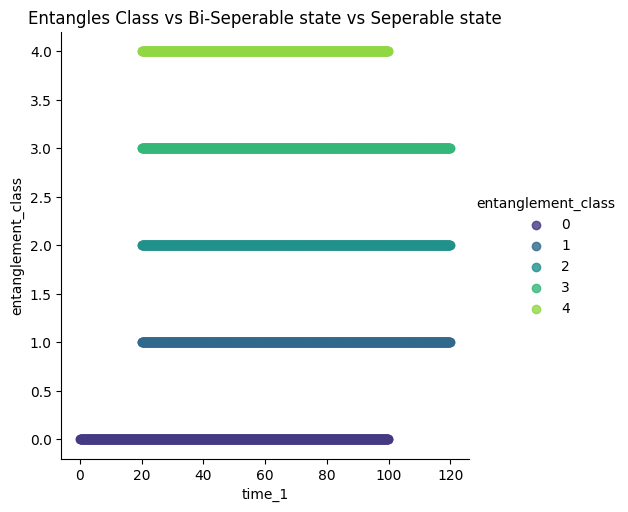

In [20]:
plt.figure(figsize=(10, 10))
sns.lmplot(x='time_1', y='entanglement_class', hue='entanglement_class', palette='viridis', data=data)
plt.title('Entangles Class vs Bi-Seperable state vs Seperable state')
plt.xlabel('time_1')
plt.ylabel('entanglement_class')
#plt.legend(title='Label')
plt.show()

In [21]:
X = data_features
y = data_labels

### Cnstructing the circuit 

Below cells demonstrates the construction of problem-inspired quantum circuit, where it act similar to feature map circuit. The generated dataset will be encoded to the circuit for further processing.  

In [28]:
# Number of Qubit = 3

num_qubits=3
num_qubits

3

### Construction of Unitary Gate 
The below class construct the Unitary gate using krauss operators of Amplitude Damping channel, which takes parameters $\alpha$ and $\beta$ as $\gamma$(gamma) and $t$(time) respectively.

In [26]:

class AD0(Gate):
    def __init__(self, x,y, label=None):
        super().__init__('AD0', 2, [x,y], label=label)
        
        
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.unitary_mat_0()[0], [0, 1])
       
        self.definition = qc

    
    def kraus_list(self,gamma,t):
        nf= np.exp(-gamma*t)
        k1=[[1,0],[0,np.sqrt(nf)]]
        k2=[[0,np.sqrt(1-nf)],[0,0]]
        return k1,k2
    


    def unitary_mat_0(self):
        gamma = self.params[0]
        t = self.params[1]
        k_list=self.kraus_list(gamma,t)
        k0=np.array(k_list[0])
        k1=np.array(k_list[1])
        D0=sqrtm(np.identity(2)-np.matmul(k0.T.conjugate(),k0))
        D0dag=sqrtm(np.identity(2)-np.matmul(k0,k0.T.conjugate()))
        D1=sqrtm(np.identity(2)-np.matmul(k1.T.conjugate(),k1))
        D1dag=sqrtm(np.identity(2)-np.matmul(k1,k1.T.conjugate()))

        z=np.array([[1,0],[0,-1]])
        x=np.array([[0,1],[1,0]])
        y=np.array([[0,-1j],[1j,0]])

        u0= np.kron((x-1j*y)/2,D0)+ np.kron((x+1j*y)/2,D0dag)+np.kron((np.identity(2)+z)/2,k0)-np.kron((np.identity(2)-z)/2,k0.T.conjugate())
        u1= np.kron((x-1j*y)/2,D1)+ np.kron((x+1j*y)/2,D1dag)+np.kron((np.identity(2)+z)/2,k1)-np.kron((np.identity(2)-z)/2,k1.T.conjugate())


        return u0,u1


### Problem Inspired Quantum Circuit 

The problem inspired quantum circuit constructed by appending GHZ state with Amplitude Damping channel(AD) as shown in below manner. Where x[0],x[1],..x[6] are parameters passed during traing from dataset.

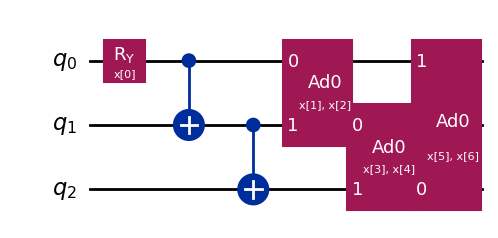

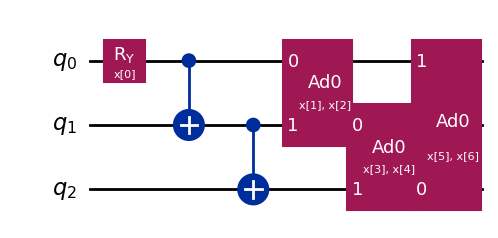

In [30]:

x = ParameterVector('x', length=7)

feature_map=QuantumCircuit(num_qubits)
feature_map.ry(x[0],0)
feature_map.cx(0,1)
feature_map.cx(1,2)

feature_map.append(AD0(x[1],x[2]),[0,1])
feature_map.append(AD0(x[3],x[4]),[1,2])
feature_map.append(AD0(x[5],x[6]),[2,0])
 

feature_map.draw()

### Constructing Customized Ansatz 
The custom ansatz include rotational gate and toffoli gates which outperformed other qiskit pre-defined ansatz. This proposed ansatz has one reps and 6 parameters, that's the minimal requirement and resuts max efficiency. 


/Users/thiru/anaconda3/envs/qiskit_1.0/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning:

Style JSON file 'idx-dark.json' not found in any of these locations: /Users/thiru/anaconda3/envs/qiskit_1.0/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/idx-dark.json, idx-dark.json. Will use default style.



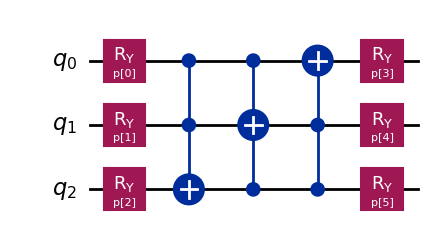

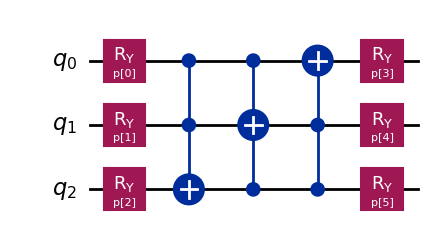

In [31]:
myansatz = QuantumCircuit(num_qubits)
p = ParameterVector('p', length=6)

myansatz.ry(p[0],0)
myansatz.ry(p[1],1)
myansatz.ry(p[2],2)


myansatz.ccx(0,1,2)
myansatz.ccx(0,2,1)
myansatz.ccx(2,1,0)

myansatz.ry(p[3],0)
myansatz.ry(p[4],1)
myansatz.ry(p[5],2)

myansatz.draw('mpl')

### Training the model 

with above problem inspired circuit and custom ansatz the model is ready for the training. 

In [35]:

optimizer = COBYLA(maxiter=80)

sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (6, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    #print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")




In [39]:
# Splitting the dataset for training and validation 

algorithm_globals.random_seed = 42

train_features, val_features, train_labels, val_labels = train_test_split(
    data_features, data_labels, test_size=0.2, random_state=42
)


In [40]:
# Reshaping the label 
train_labels = np.array(train_labels).reshape(-1, 1)

In [42]:
num_epochs = 1
train_losses = []
val_losses = []

def compute_loss(predictions, labels):
    return log_loss(labels, predictions)


### VQC 

The circuit, ansatz and optimizer appended to VQC, pre-defined by qiskit for training. 

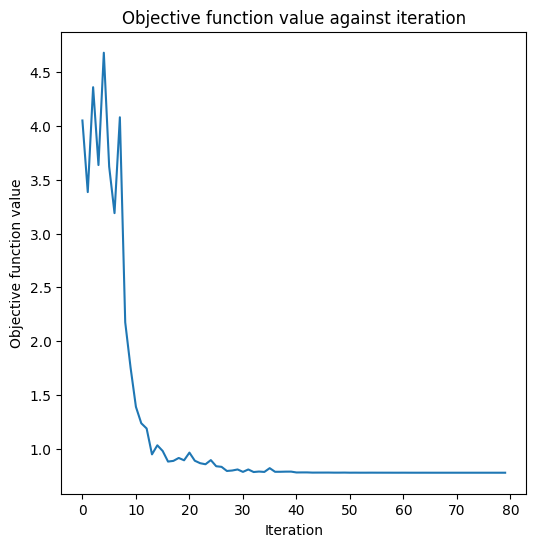

In [43]:

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=myansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Training loop over epochs
for epoch in range(num_epochs):
    # Clear previous objective function values
    objective_func_vals = []

    # Fit the model
    start = time.time()
    vqc.fit(train_features, train_labels)
    elapsed = time.time() - start

    # Predict on training and validation data
    train_predictions = vqc.predict(train_features)
    val_predictions = vqc.predict(val_features)

    


In [47]:
# VQC Score calculated on trained model 
vqc.score(train_features, train_labels)

0.9919270833333333

In [48]:
train_score_q4 = vqc.score(train_features, train_labels)
val_score_q4 = vqc.score(val_features, val_labels)

print(f"Training dataset: {train_score_q4:.2f}")
print(f"Validation dataset:     {val_score_q4:.2f}")

Training dataset: 0.99
Validation dataset:     0.99


In [49]:
# Prediction over validation dataset 
prediction = vqc.predict(val_features)

In [50]:
# Mapping the results 
y_true = val_labels
y_pred = vqc.predict(val_features)

### Calculting Metrics

In [51]:
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15  # small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


loss = binary_cross_entropy_loss(y_true, y_pred)

print("Binary Cross-Entropy Loss:", loss)

Binary Cross-Entropy Loss: -37.094065466774424


In [52]:
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 0.22083333333333333
R-squared Score: 0.8829827665215259


In [53]:
# Accuracy 
accuracy_score(y_true, y_pred)

0.9854166666666667

In [54]:
val_predictions = vqc.predict(val_features)

In [55]:
confusion_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(confusion_matrix)


Confusion Matrix:
[[184   0   1   0  13]
 [  0 219   0   0   0]
 [  0   0 197   0   0]
 [  0   0   0 190   0]
 [  0   0   0   0 156]]


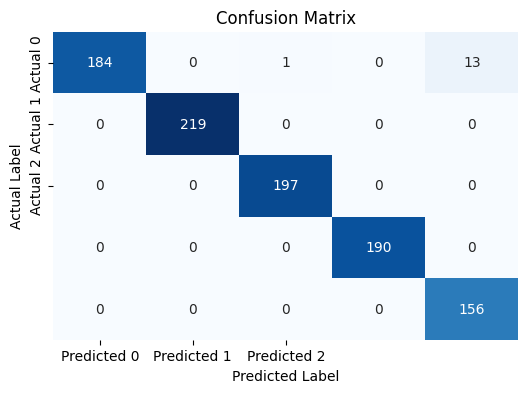

In [56]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])

# Add labels and title
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Calculation of other Performance metrics 

In [57]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [58]:
Recall = TPR
Precision =PPV
f1_score = 2*((Precision*Recall)/(Precision+Recall))

In [59]:
print(f'False Positive - {FP} \nFalse negative - {FN},\nTrue positive - {TP}, \nTrue negative - {TN} ')
print(f'\nTrue positive rate - {TPR}, \nTrue Negative rate - {TNR}, \nPrecision - {PPV}')
print(f'Accuracy - {ACC}')

print(f'Recall - {TPR}')
print(f'F1 Score - {f1_score}')

False Positive - [ 0  0  1  0 13] 
False negative - [14  0  0  0  0],
True positive - [184 219 197 190 156], 
True negative - [762 741 762 770 791] 

True positive rate - [0.92929293 1.         1.         1.         1.        ], 
True Negative rate - [1.         1.         0.99868938 1.         0.98383085], 
Precision - [1.         1.         0.99494949 1.         0.92307692]
Accuracy - [0.98541667 1.         0.99895833 1.         0.98645833]
Recall - [0.92929293 1.         1.         1.         1.        ]
F1 Score - [0.96335079 1.         0.99746835 1.         0.96      ]


In [60]:
print(f'fpr - {FPR},\ntpr - {TPR}')

fpr - [0.         0.         0.00131062 0.         0.01616915],
tpr - [0.92929293 1.         1.         1.         1.        ]


###  Calculating circuit depth 
 The circuit depth plays crcuial role in quantum circuit particularly when the circuit get executed in the hardware. The below cell shows the circuit depth of Problem inspired Quantumn circuit and custom ansatz.

In [63]:
print(feature_map.depth(),myansatz.depth())

6 5
